#**DBNs for Visual Concept Learning**
###*Cognition and Computation* - Project
Francesco Carlesso - ID: 2125806 - 30/08/2024

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import torch.nn.functional as functional
from tqdm.notebook import tqdm
from string import ascii_uppercase
from sklearn.metrics import confusion_matrix

from DBN import DBN

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


The chosen dataset is the *EMNIST letters*

In [5]:
# rotate and flip the image
def correct_orientation(img):
    img = torch.rot90(img, k=1, dims=(1, 0))  # Rotate 90 degrees counterclockwise
    img = torch.flip(img, dims=[1])  # Flip horizontally
    return img

# map target labels to letters
def target_to_letter(target):
    return ascii_uppercase[target]

In [6]:
%%capture
emnist_tr = tv.datasets.EMNIST(root="../emnist", split = 'letters', train=True, download=True)
emnist_te = tv.datasets.EMNIST(root="../emnist", split = 'letters', train=False, download=True)

emnist_tr.data = emnist_tr.data / 255
emnist_te.data = emnist_te.data / 255

emnist_tr.data = emnist_tr.data.to(device)
emnist_te.data = emnist_te.data.to(device)
emnist_tr.targets = emnist_tr.targets.to(device)
emnist_te.targets = emnist_te.targets.to(device)

In [7]:
# adjusting the labels
emnist_tr.targets -=1
emnist_te.targets -=1

In [8]:
emnist_tr.data.shape

torch.Size([124800, 28, 28])

In [9]:
emnist_te.data.shape

torch.Size([20800, 28, 28])

The image shows the letter: J


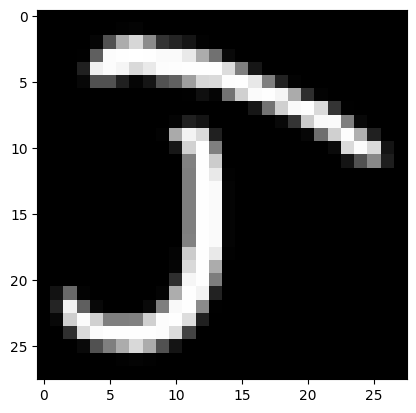

In [10]:
idx = 10
img = correct_orientation(emnist_tr.data[idx].cpu())
letter = target_to_letter(emnist_tr.targets[idx].cpu().item())
print(f"The image shows the letter: {letter}")
plt.imshow(img, cmap='gray')
plt.show()

In this first section I layed out the necessary steps to start the project, such as importing the DBN library and all of the other modules to manipulate the data. I defined the functions `correct_orientation` and `target_to_letter` to better visualize and interpret the images when they are printed, since the EMNIST dataset stores them in a "non-convetional" way, also considering that the targets are not letters by default, but instead they are the numbers associated with the alphabetical order.

After downlading the separate training and test data, a simple normalization is performed to bring the RGB values of each single pixel in the range [0, 1], then the data is sent to the device, which we hope to be a GPU, for faster processing.
Targets in the dataset are numbers in the range [1, 26], and to account for the 0-based indexing in python, these are adjusted altogether to be in [0, 25].

Images are 28 by 28 pixels and the splitted data is represented by two three-dimentional tensors with 124,800 training examples, and 20,800 testing examples. All classes are perfectly balanced.

The last cell shows one example from the training data, based on the index given. One can change the index to explore diffent handwritten letters representatiions and their corresponding label.

##**Training**

In [11]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[700, 700, 700], # same size of hiddel layers to have a fair comparison between them afterwards
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [12]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    emnist_tr.data,
    emnist_tr.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2611     |0.0393       |414.6658   |5.6749     |
|20    |1.2049     |0.0367       |399.5491   |6.0566     |
|30    |1.1938     |0.0353       |395.6807   |5.4980     |
|40    |1.1899     |0.0356       |394.4702   |5.4757     |
|50    |1.1859     |0.0359       |393.3798   |5.5649     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9377     |0.0247       |313.3074   |3.5334     |
|20    |0.9074     |0.0234       |321.0389   |3.7534     |
|30    |0.9001     |0.0228       |321.5826   |3.5242     |
|40    |0.8954     |0.0240       |321.1311   |4.0391     |
|50    |0.8955     |0.0230       |321.7613   |3.8054     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8800     |0.0250       |306.6491   |3.5769     |
|20    |0.7979     |0.0221       |295.6741   |3.880

For training, I decided to keep a pretty standard configuration of the hyperparameters, the only thing to notice is the structure of the hidden layers, which are all kept at the same size for better comparability when perfoming the linear readouts afterwards.

We can observe the *average reconstruction error* decrease throughout the greedy advancement on the layers, and thus we can be satisfied with the training.

##**Internal Representation Analysis**

**Receptive Fields**

In [13]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

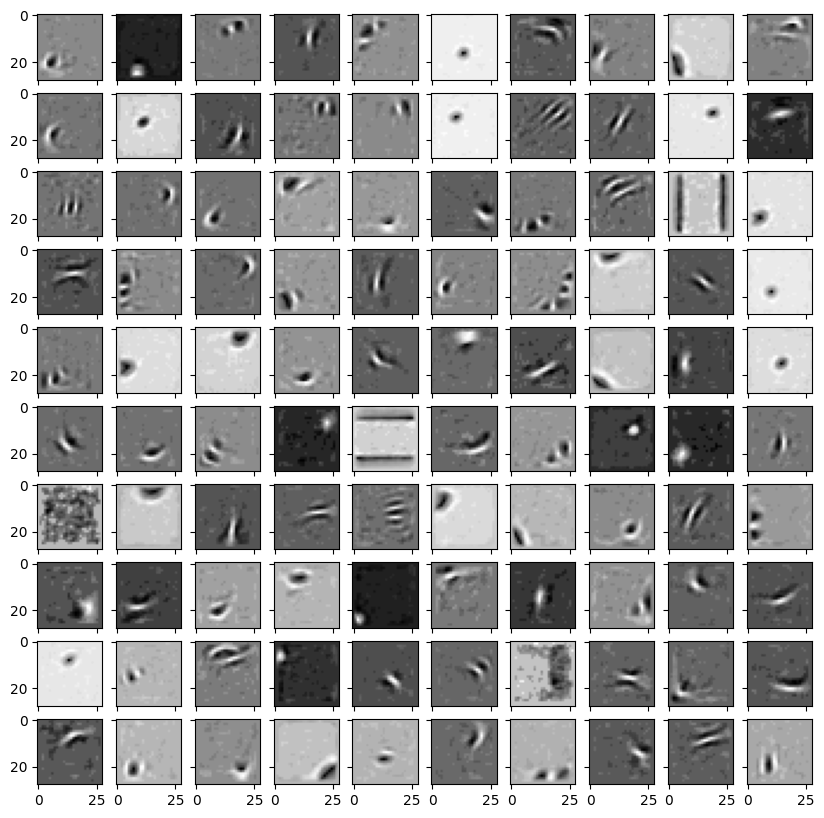

In [14]:
w1 = get_weights(dbn_emnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

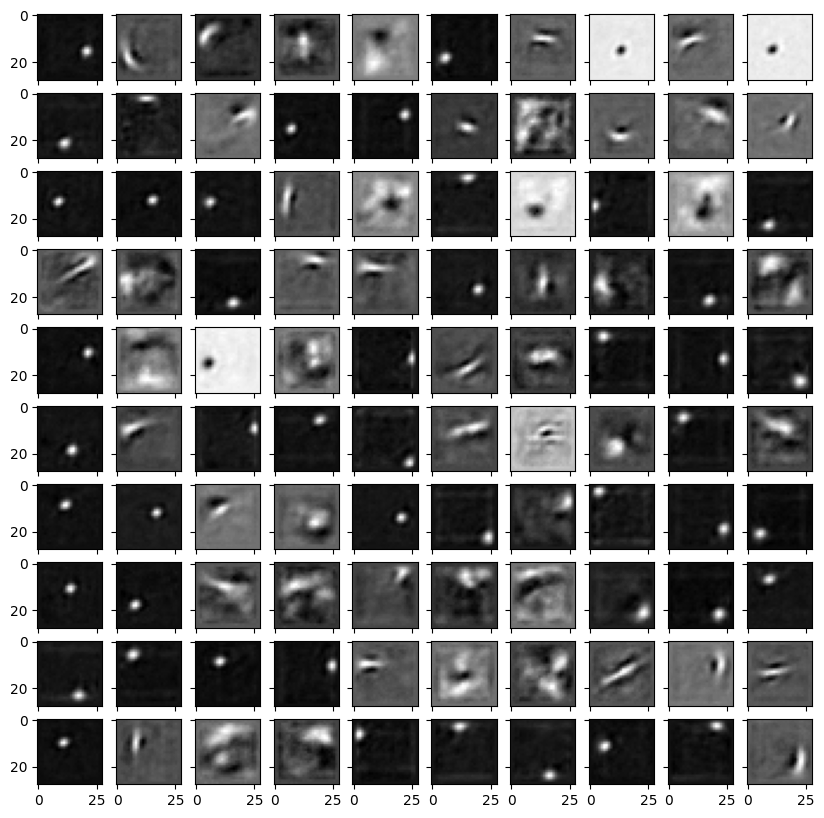

In [15]:
w1 = get_weights(dbn_emnist, layer=0)
w2 = get_weights(dbn_emnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

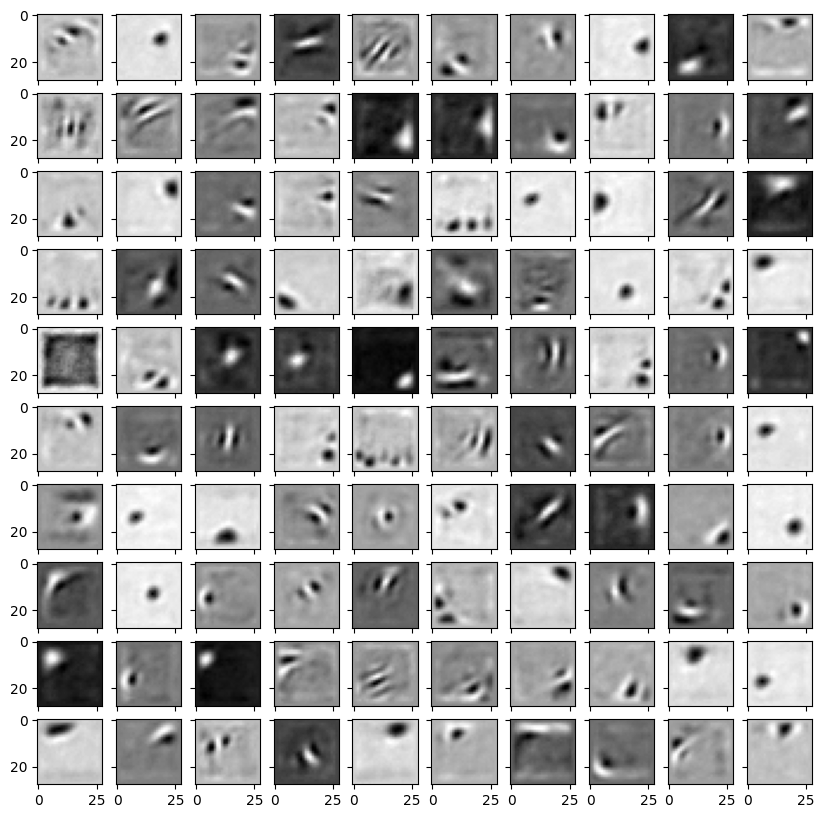

In [16]:
w1 = get_weights(dbn_emnist, layer=0)
w2 = get_weights(dbn_emnist, layer=1)
w3 = get_weights(dbn_emnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)
w_product_23 = (w_product_12 @ w3)
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

Through this feature visualition we can analyze how the receptive fields of different layers in the architecture are breaking down particular patterns in the data to better learn the representation.

We can observe clearer "shapes" in the 1st and 3rd hidden layers, while the 2nd hidden layer seems to be dominated by "spots", which we can assume do not carry as much information as a more complex shape does.

**Hierarchical Clustering**

In [17]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [18]:
hidden_repr_1 = get_kth_layer_repr(emnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)

In [19]:
def get_mask(label):
  labels = emnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)
    for label in range(26)
  }

def get_hidden_reprs_matrix(hidden_repr):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(26)])

In [20]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [21]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
  labels = [target_to_letter(i) for i in range(mean_repr_matrix.shape[0])]
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=labels)
  ax.set_title(title)
  plt.xticks(rotation=0)

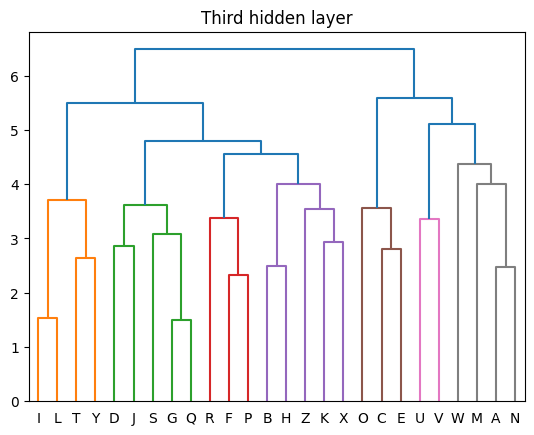

In [22]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

Hierarchical clustering helps in understaning how the DBN is managing the representations of the letters and wether these are close or far from each other, using a dendrogram.

In our case, we can see that the closest representations are those of letters (I, L) and (G, Q), while the biggest distiction is between the group (O, C, E, U, V, W, M, A, N) and all of the other letters.

##**Linear Readouts**


In [23]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 26)

  def forward(self, x):
    return self.linear(x)

In [24]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [25]:
def train_supervised(network, input_data, epochs=1000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.8)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = emnist_tr.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == epochs - 1:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [26]:
train_supervised(linear1, hidden_repr_1)

epoch :   1/1000, loss = 3.2774
epoch : 101/1000, loss = 0.8804
epoch : 201/1000, loss = 0.7268
epoch : 301/1000, loss = 0.6488
epoch : 401/1000, loss = 0.5983
epoch : 501/1000, loss = 0.5619
epoch : 601/1000, loss = 0.5338
epoch : 701/1000, loss = 0.5113
epoch : 801/1000, loss = 0.4927
epoch : 901/1000, loss = 0.4770
epoch : 1000/1000, loss = 0.4636


In [27]:
train_supervised(linear2, hidden_repr_2)

epoch :   1/1000, loss = 3.2743
epoch : 101/1000, loss = 0.9466
epoch : 201/1000, loss = 0.8046
epoch : 301/1000, loss = 0.7291
epoch : 401/1000, loss = 0.6781
epoch : 501/1000, loss = 0.6401
epoch : 601/1000, loss = 0.6100
epoch : 701/1000, loss = 0.5853
epoch : 801/1000, loss = 0.5645
epoch : 901/1000, loss = 0.5467
epoch : 1000/1000, loss = 0.5313


In [28]:
train_supervised(linear3, hidden_repr_3)

epoch :   1/1000, loss = 3.2620
epoch : 101/1000, loss = 0.8465
epoch : 201/1000, loss = 0.6965
epoch : 301/1000, loss = 0.6218
epoch : 401/1000, loss = 0.5739
epoch : 501/1000, loss = 0.5396
epoch : 601/1000, loss = 0.5132
epoch : 701/1000, loss = 0.4922
epoch : 801/1000, loss = 0.4748
epoch : 901/1000, loss = 0.4602
epoch : 1000/1000, loss = 0.4477


In [29]:
hidden_repr_1_test = get_kth_layer_repr(emnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [30]:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [31]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [32]:
compute_accuracy(predictions_test1, emnist_te.targets)

0.8640865683555603

In [33]:
compute_accuracy(predictions_test2, emnist_te.targets)

0.844326913356781

In [34]:
compute_accuracy(predictions_test3, emnist_te.targets)

0.8682692050933838

Performing linear readouts is useful to understand how disentangled become the representations after each hidden layer. As we can see, the accuracy of the 2nd hidden layer drops with respect to the 1st, but then it is regained by the 3rd hidden layer with also a slight increase over the 1st. This behaviour seems strange but it is consistent with what we observed during the receptive fields analysis, because the 2nd hidden layer was seemingly not learning very significant patterns. In any case the 3rd layer is able to get back on track and reach an acceptable level of accuracy.

##**Feed-Forward Network**

In [35]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 26)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [36]:
ffnn = Feedforward(700, 700, 700).to(device)

In [37]:
# choosing the number of epochs to match the training time of the readout layer.
train_supervised(ffnn, emnist_tr.data.reshape((124800, 784)), 1000)

epoch :   1/1000, loss = 3.2572
epoch : 101/1000, loss = 1.3191
epoch : 201/1000, loss = 0.8063
epoch : 301/1000, loss = 0.4273
epoch : 401/1000, loss = 0.3535
epoch : 501/1000, loss = 0.2945
epoch : 601/1000, loss = 0.3475
epoch : 701/1000, loss = 0.2332
epoch : 801/1000, loss = 0.2135
epoch : 901/1000, loss = 0.2004
epoch : 1000/1000, loss = 0.1659


In [38]:
predictions_ffnn = ffnn(emnist_te.data.reshape((20800, 784)))

In [39]:
compute_accuracy(predictions_ffnn, emnist_te.targets)

0.9183653593063354

A classic FFNN is trained and tested on the same data to have a comparison with the generative model. The hidden layers' structure is the same of the DBN and it is trained for the same number of epochs as the linear readouts. It can be seen that this model actually outperforms the DBN in terms of accuracy for this particular task, the FFNN is able to reduce the loss function much more for the same epochs and thus obtains a better performance.

The result above could be simply explained by the fact that the FFNN is optimized specifically for the classification task from the very beginning, with all layers learning together to minimize the loss. This direct and unified approach contrasts with the DBN, where the layer-wise unsupervised pretraining may not fully align the features with the classification task, leading to slower loss reduction when training linear classifiers.

It is in fact important to notice how much this supervised architecture is able to reduce the loss given the same number of epochs, and also necessary to say that a far better performance could have been achieved in the DBN layers if only trained for longer. I have personally tried to train the hidden layers with 30,000 epochs, reaching losses of around 0.2 and significantly greater accuracies. Anyways, considering this will make the final point about DBNs even stronger.

##**Confusion Matrices and Psycometric Curves**


In [40]:
def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape, device = device)*noise_level
  data_noise = data + random_gaussian_tensor
  data_noise = torch.clamp(data_noise, 0, 1)
  return data_noise

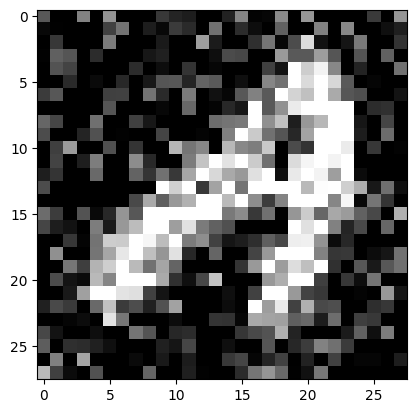

In [41]:
noise_level = 0.3
emnist_test_with_noise = inject_noise(emnist_te.data, noise_level)
__ = plt.imshow(correct_orientation(emnist_test_with_noise[100].reshape(28, 28).to("cpu")), cmap="gray")

In [42]:
def plot_confusion_matrix(predictions, targets, title):
    predictions_indices = predictions.max(axis=1).indices.cpu().numpy()
    targets = targets.cpu().numpy()
    cm = confusion_matrix(targets, predictions_indices)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticks(range(26))
    ax.set_yticks(range(26))
    ax.set_xticklabels([target_to_letter(i) for i in range(26)])
    ax.set_yticklabels([target_to_letter(i) for i in range(26)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [43]:
def get_accuracy_and_confusion_matrix_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_te.data, noise_level)

  hidden_repr_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_te.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_te.targets)

  plot_confusion_matrix(predictions_first_hidden_noisy, emnist_te.targets, f"Confusion Matrix - H1 (Noise {noise_level})")
  plot_confusion_matrix(predictions_second_hidden_noisy, emnist_te.targets, f"Confusion Matrix - H2 (Noise {noise_level})")
  plot_confusion_matrix(predictions_third_hidden_noisy, emnist_te.targets, f"Confusion Matrix - H3 (Noise {noise_level})")
  plot_confusion_matrix(predictions_ffnn_noisy, emnist_te.targets, f"Confusion Matrix - FFNN (Noise {noise_level})")

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [44]:
def plot_noise_robustness_and_confusion_matrices(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_and_confusion_matrix_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

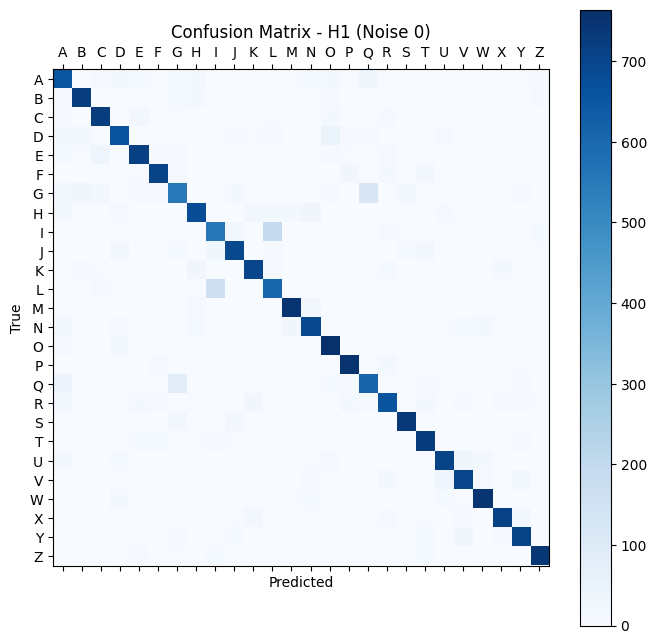

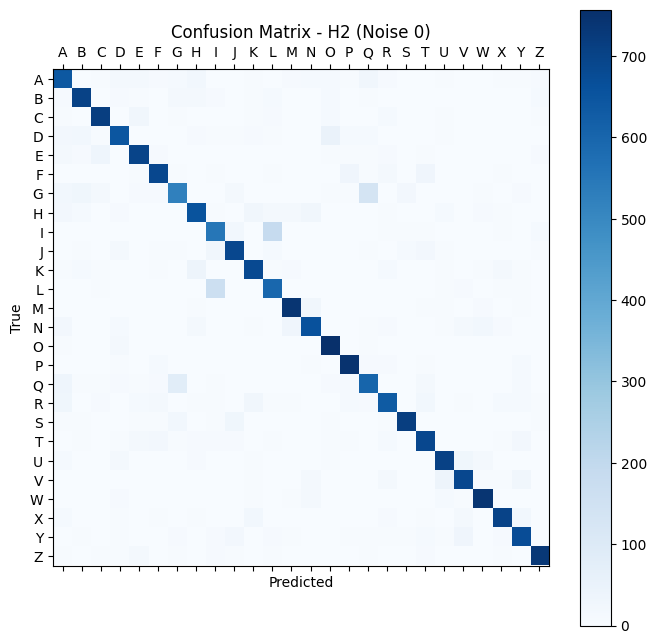

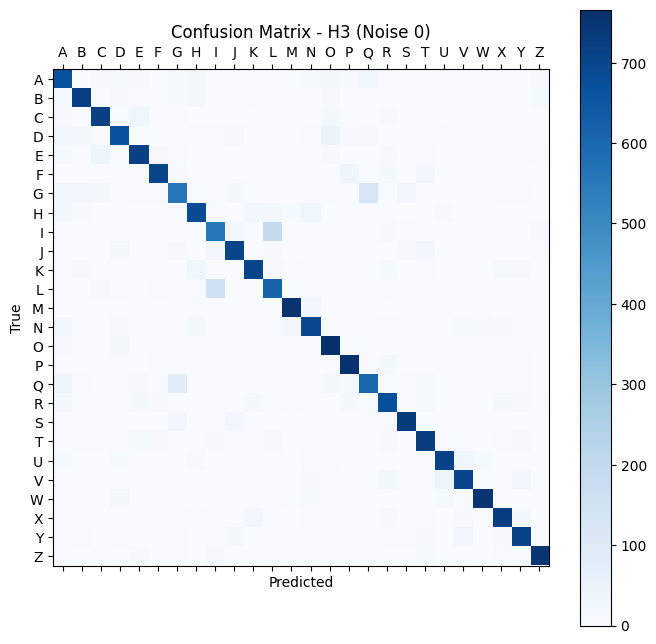

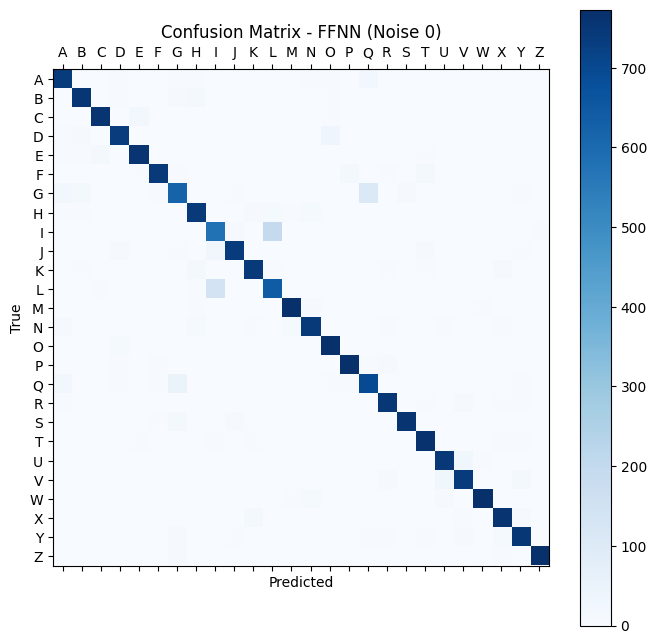

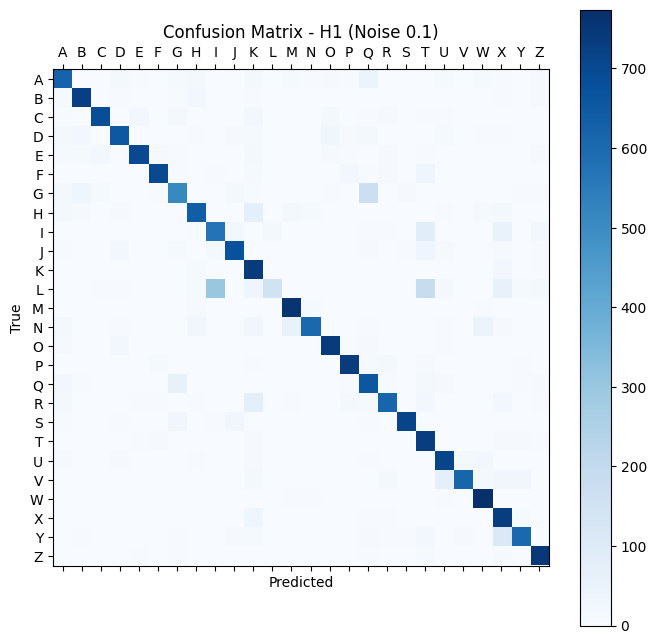

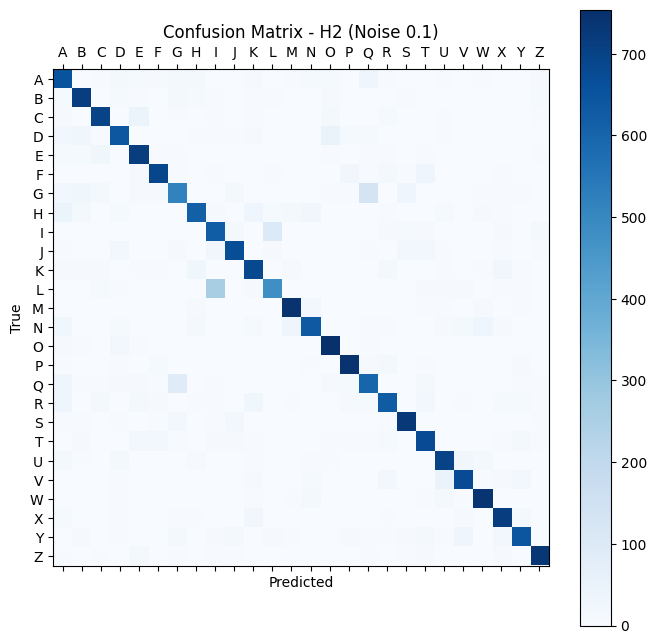

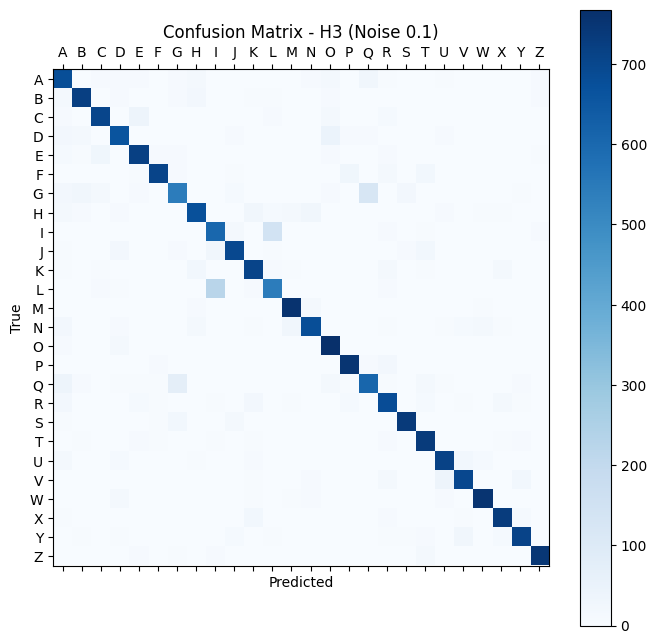

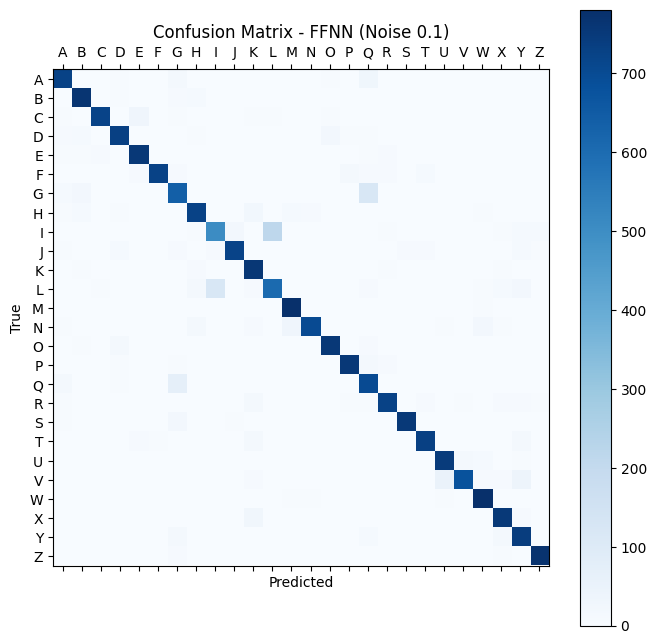

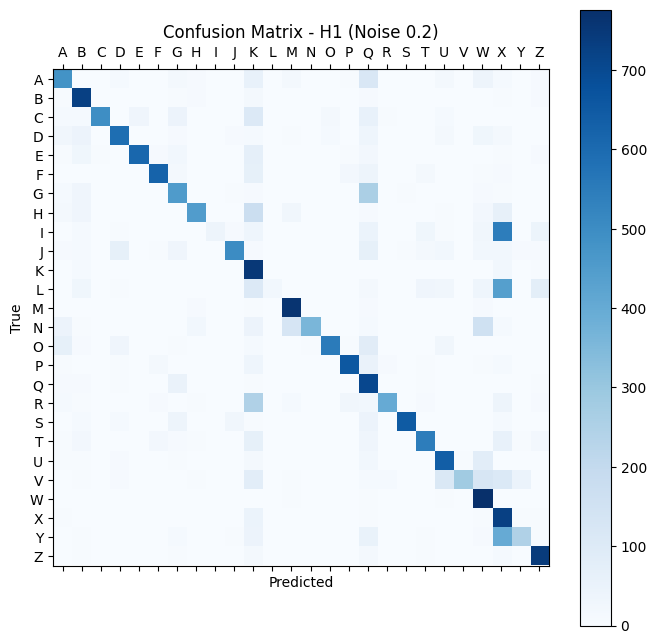

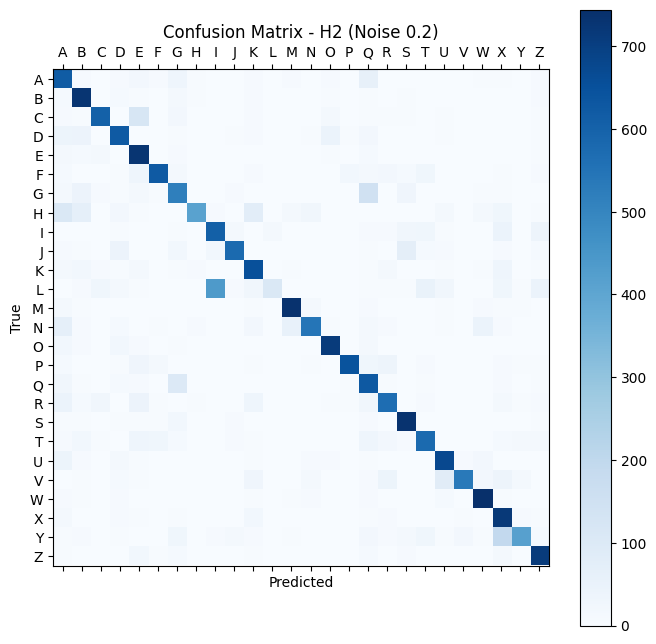

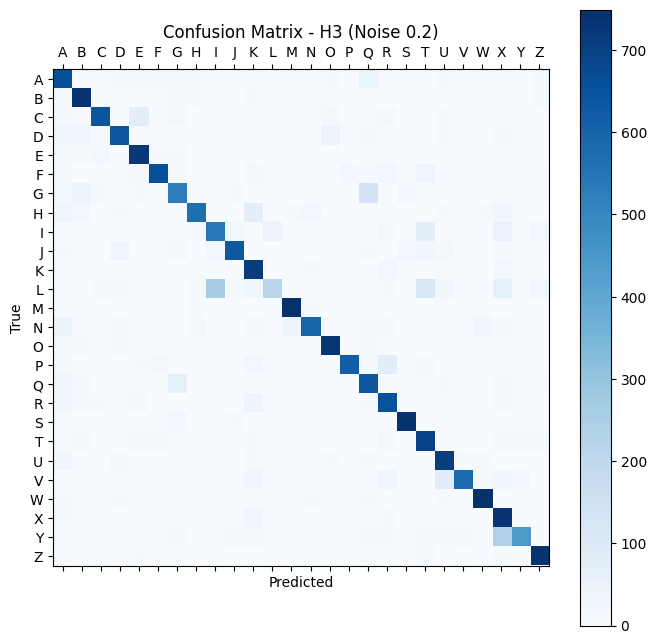

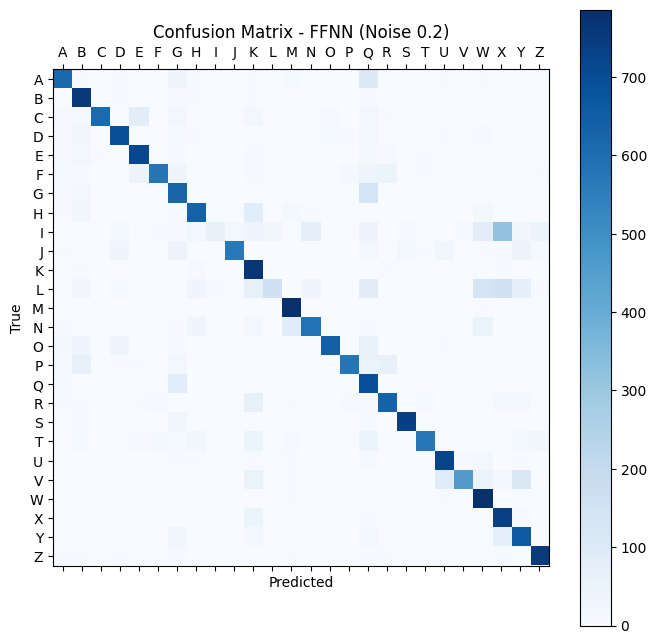

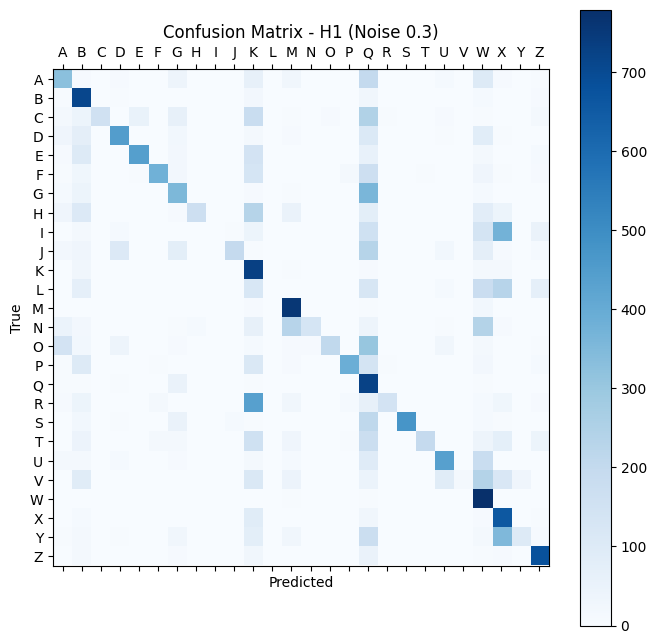

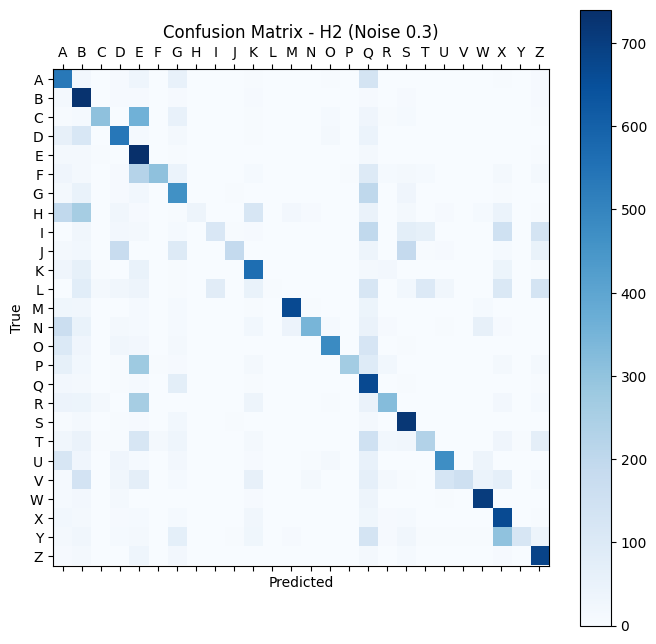

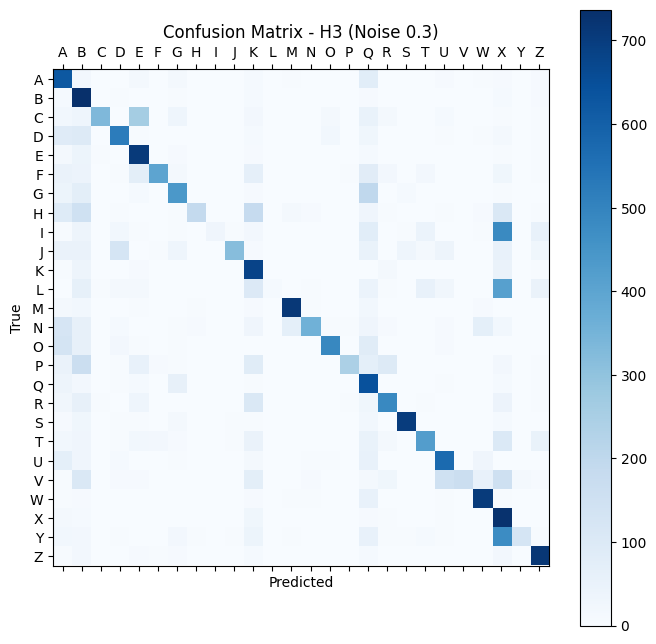

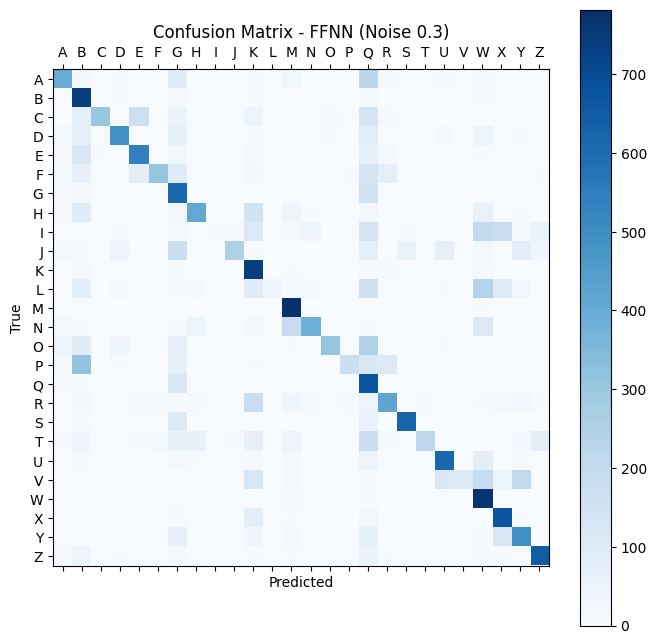

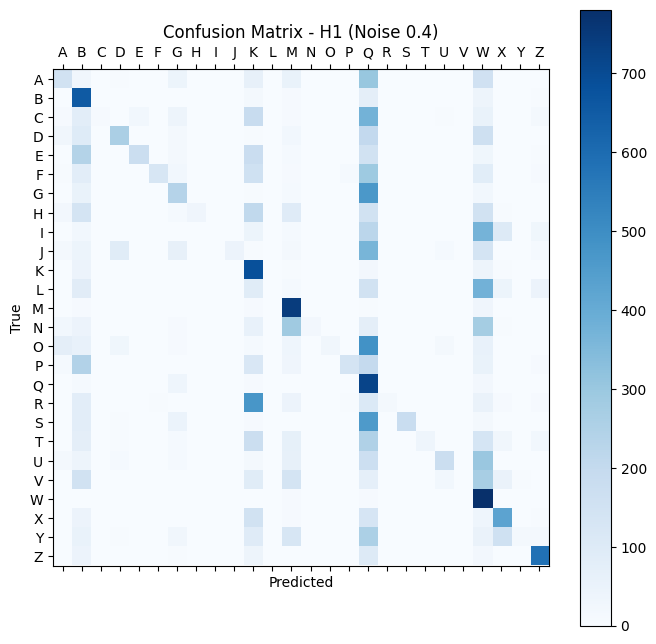

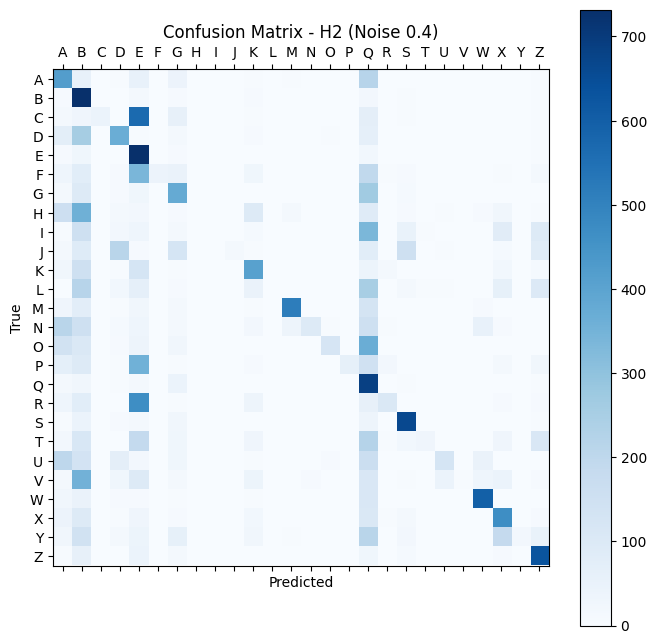

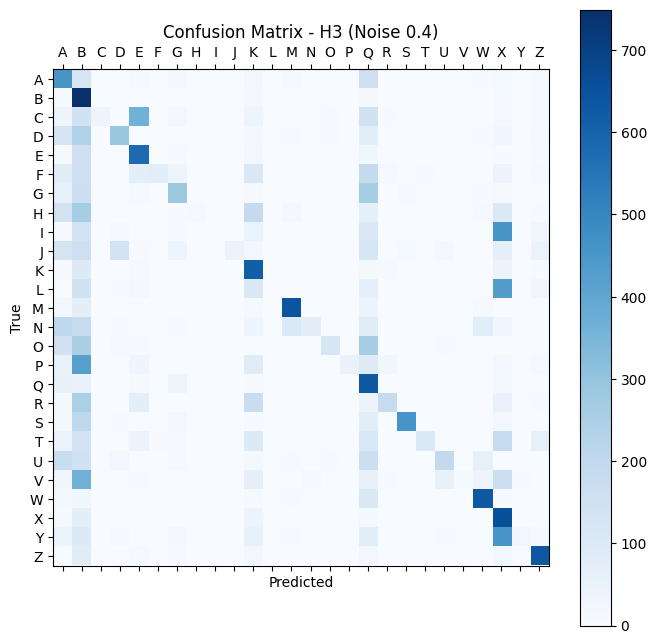

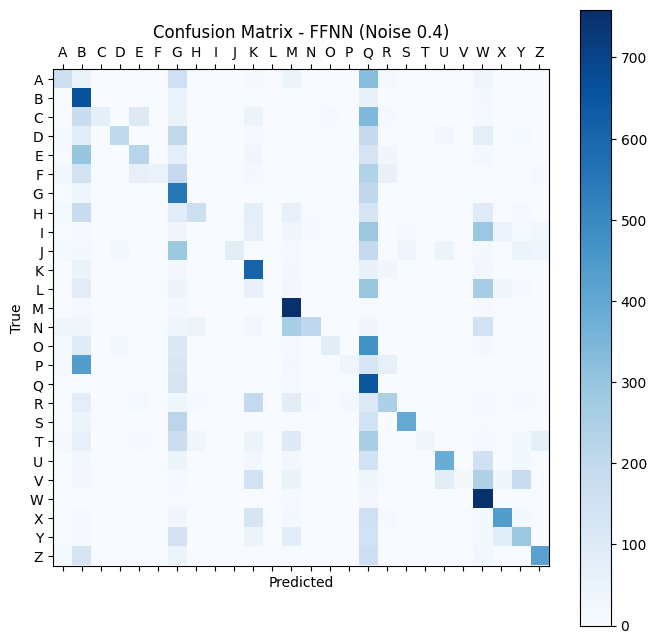

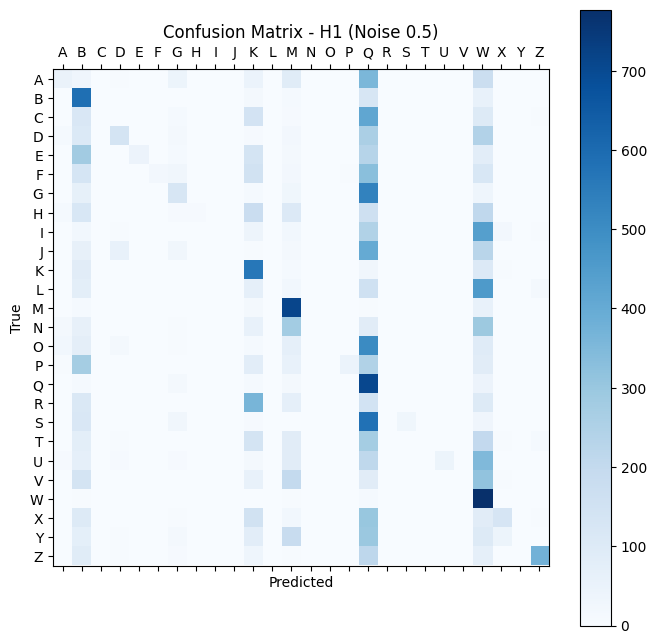

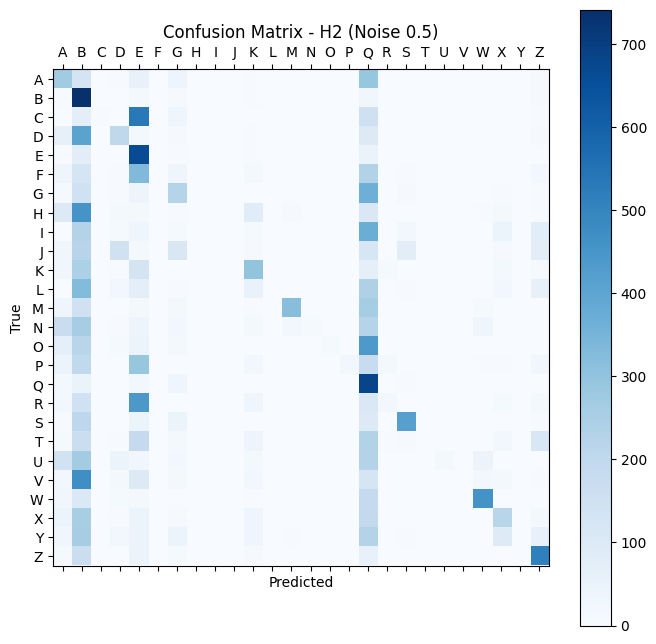

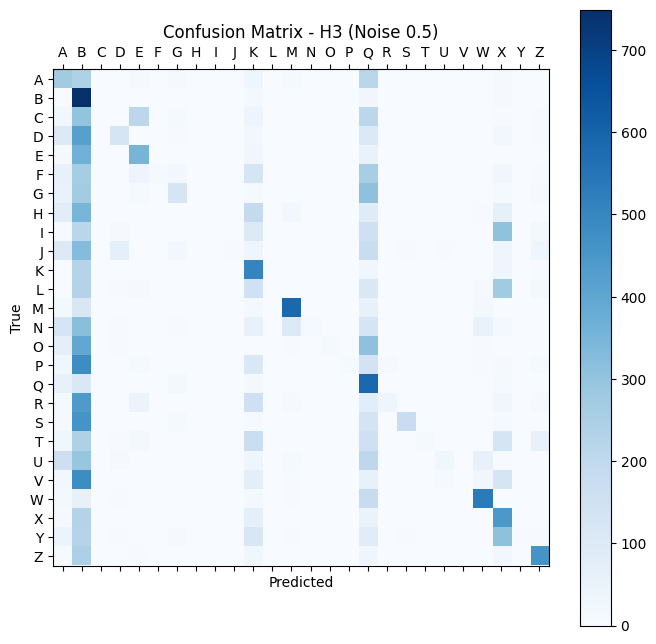

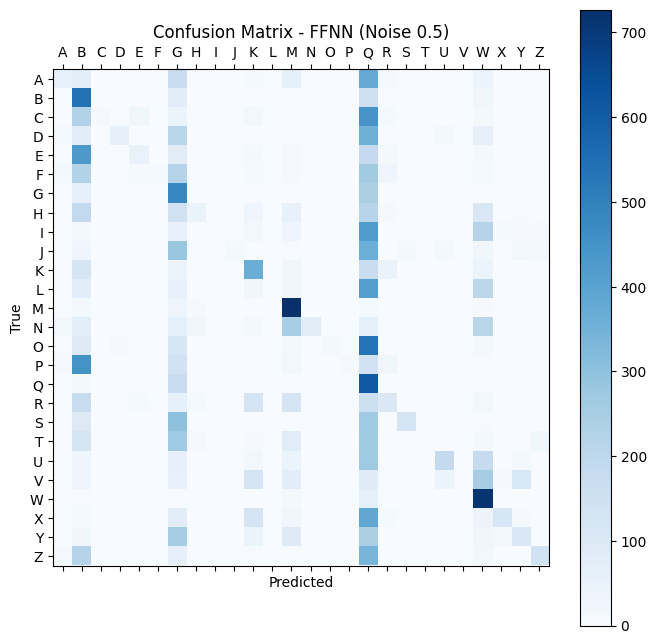

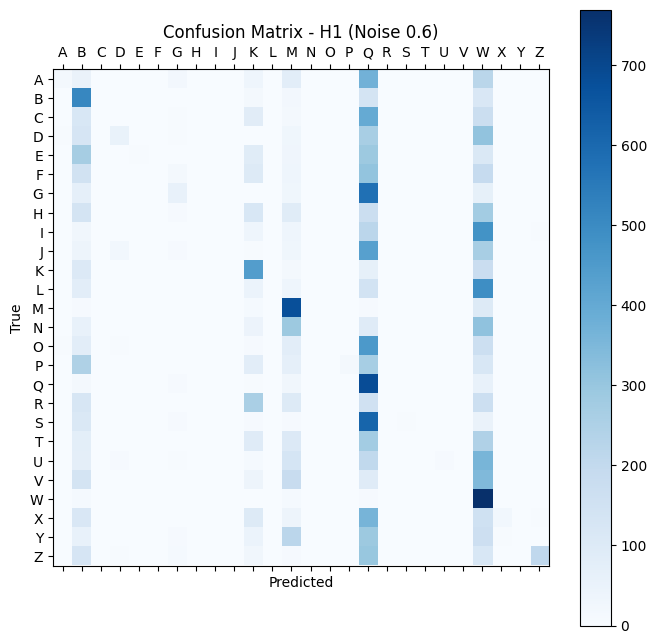

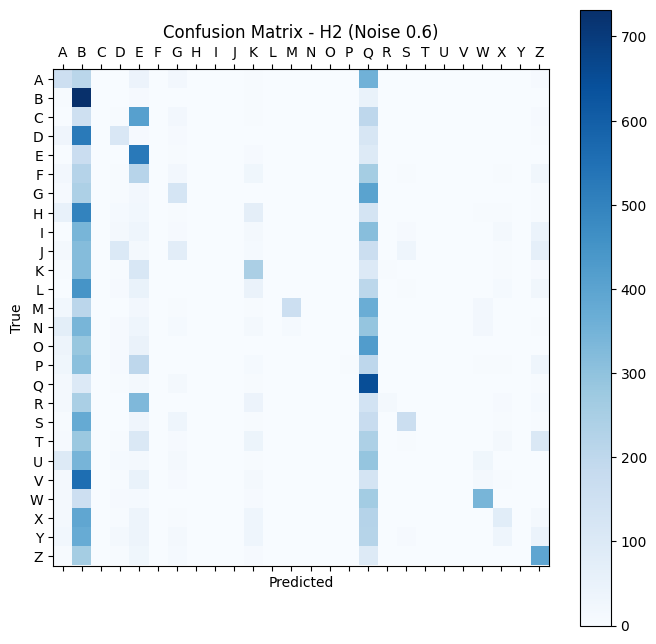

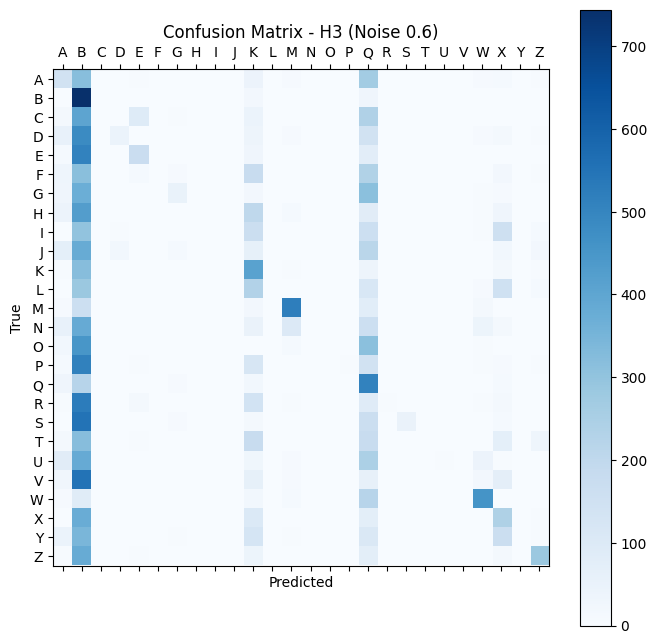

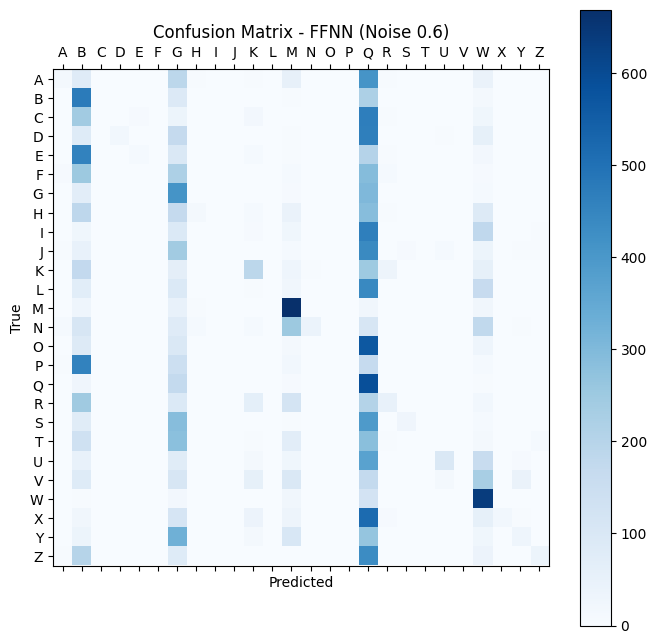

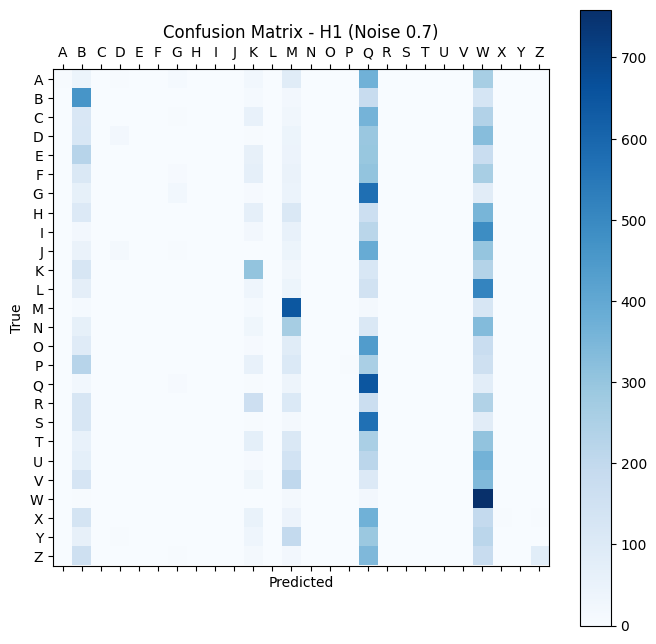

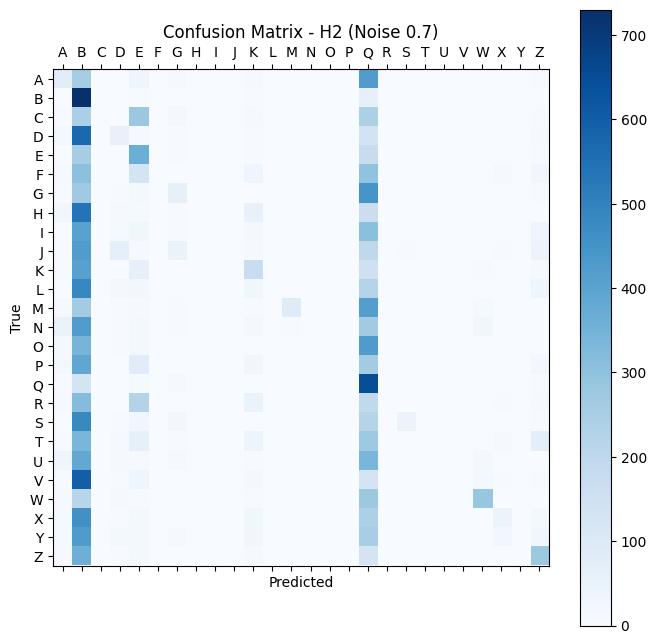

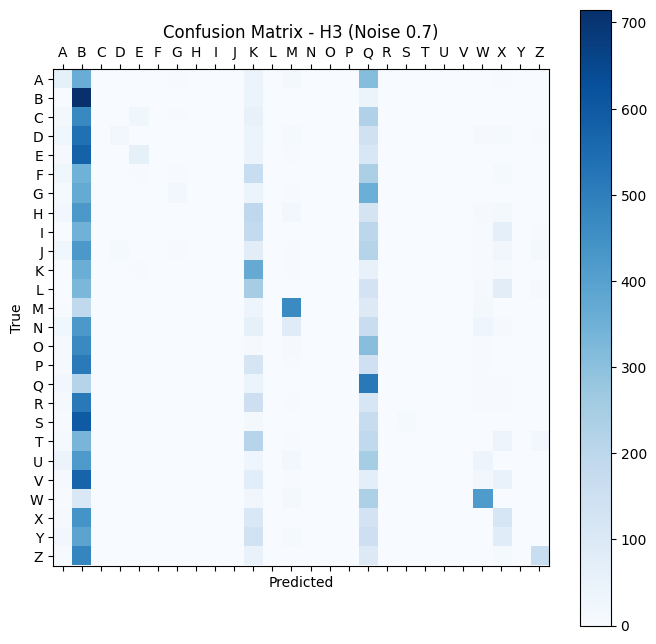

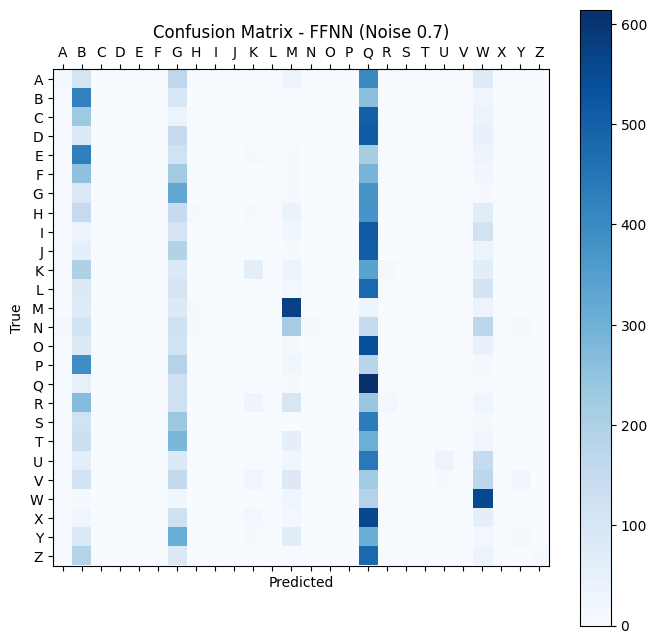

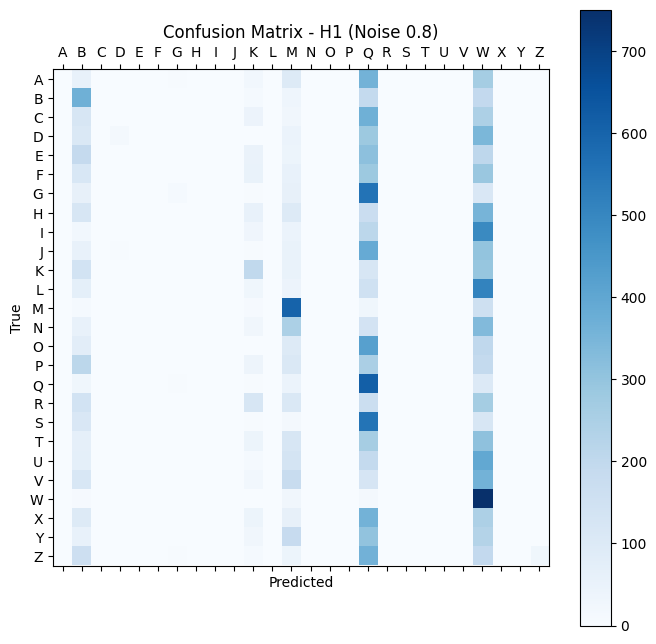

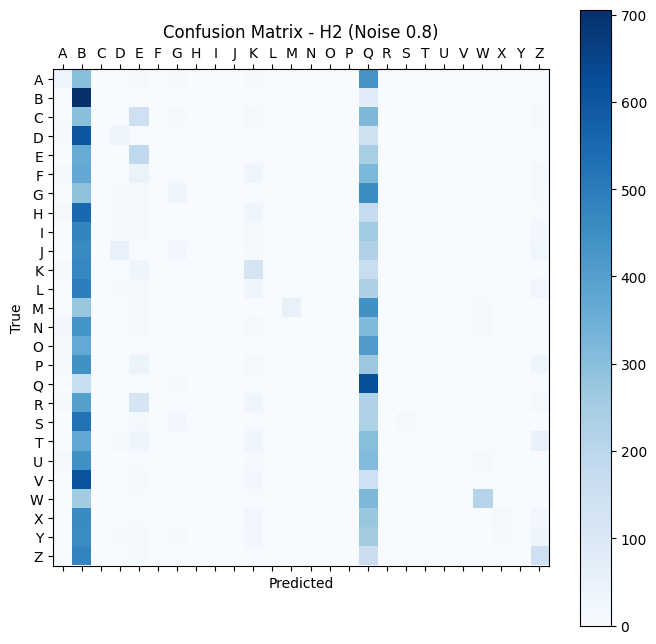

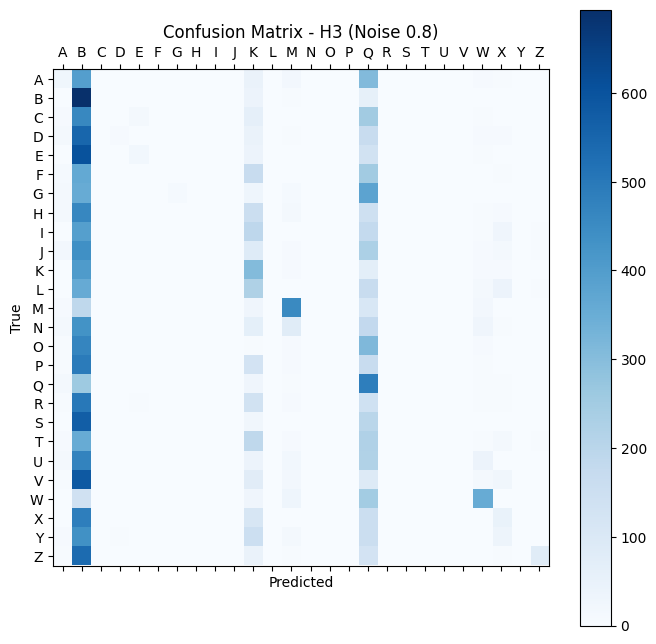

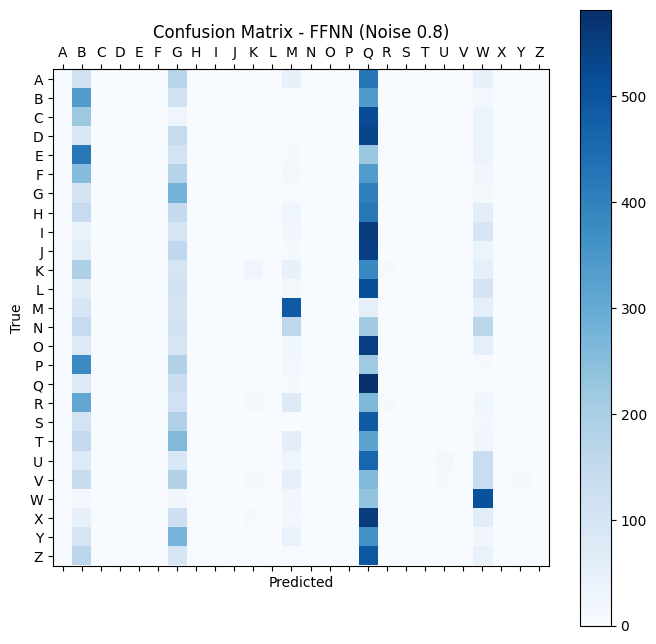

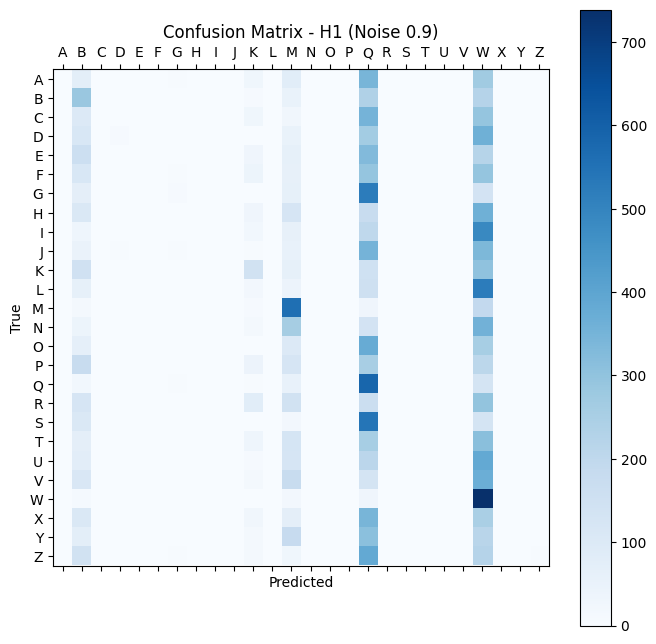

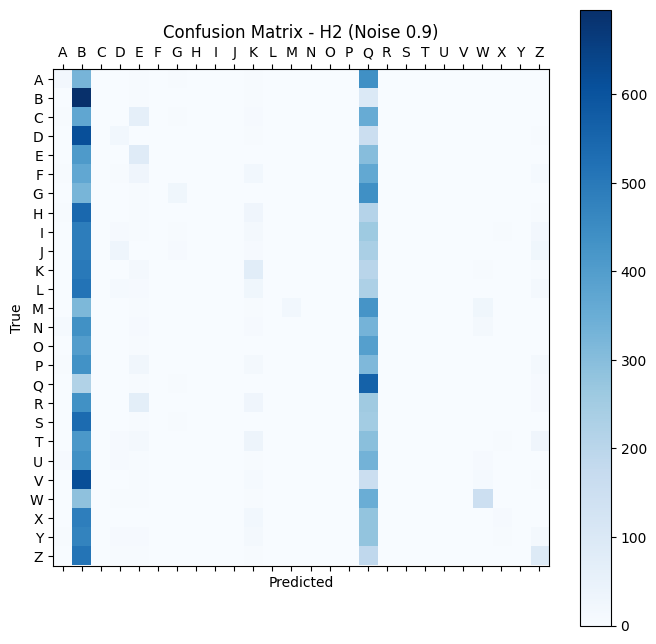

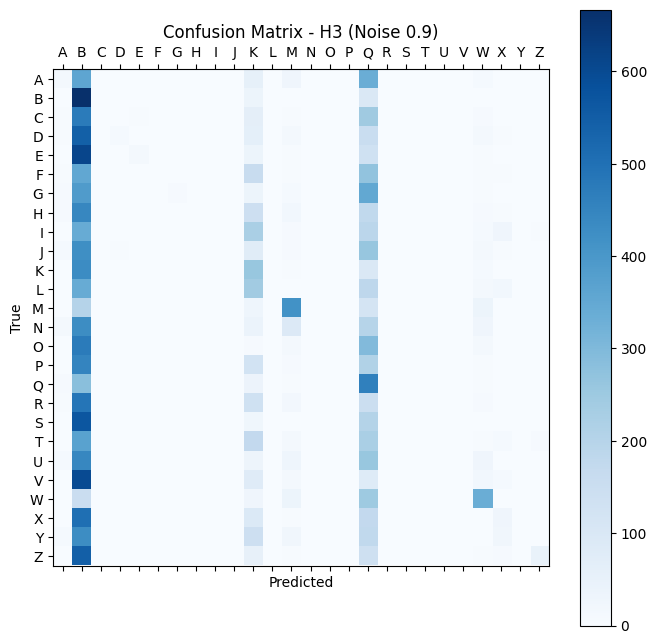

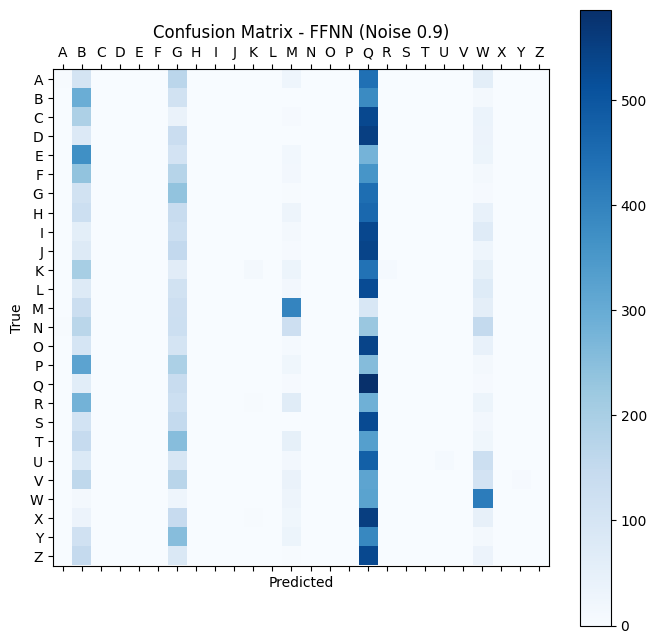

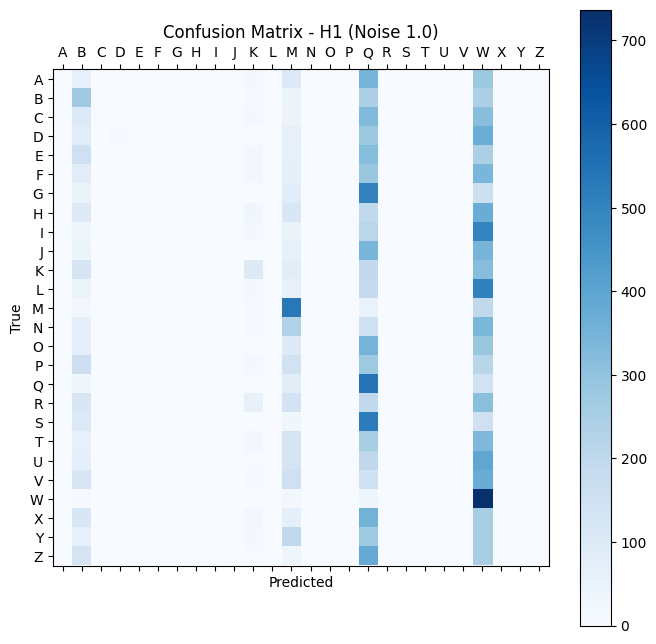

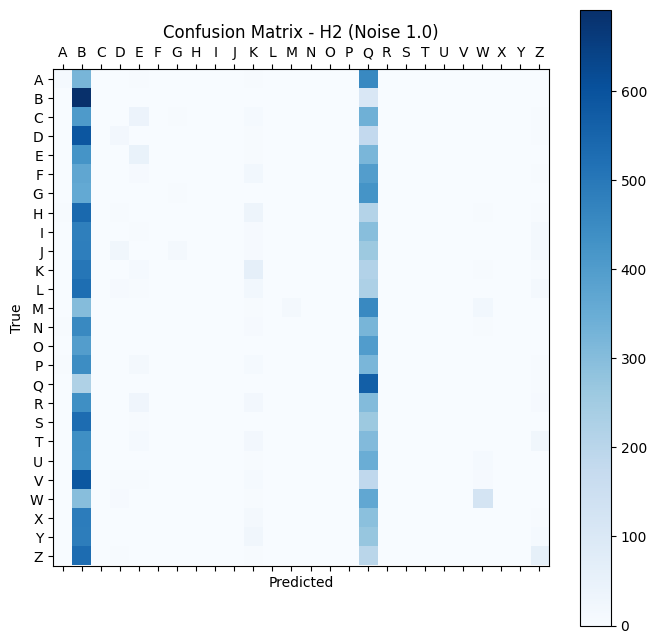

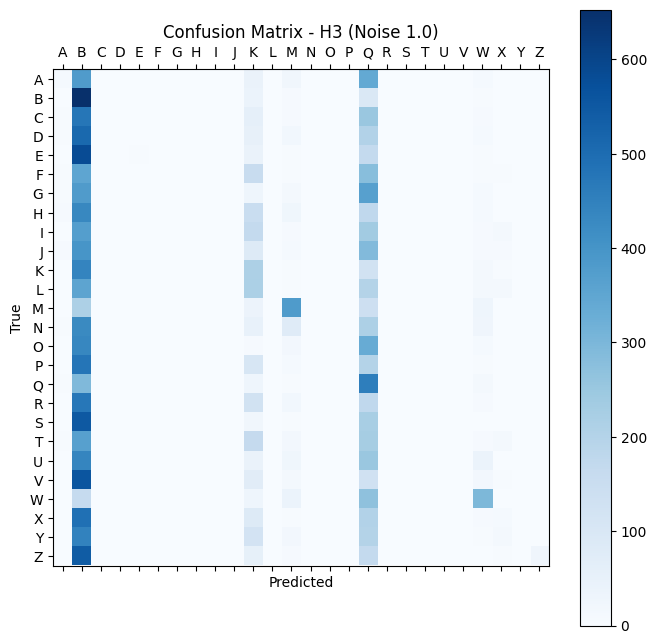

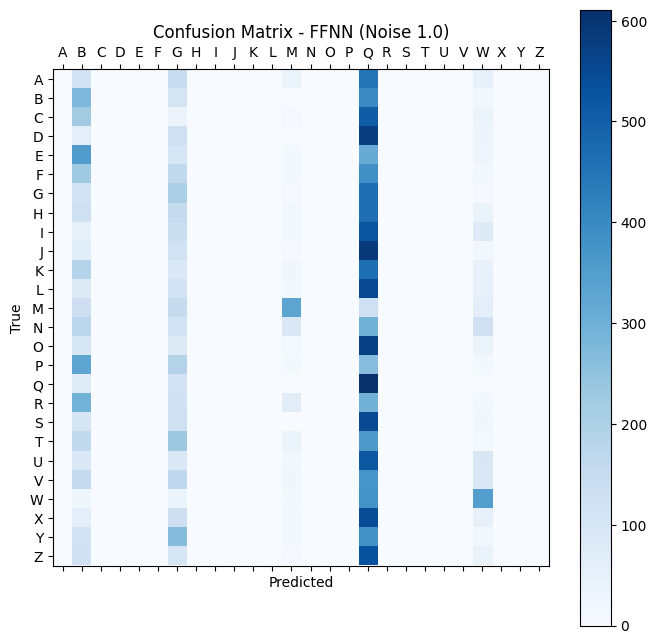

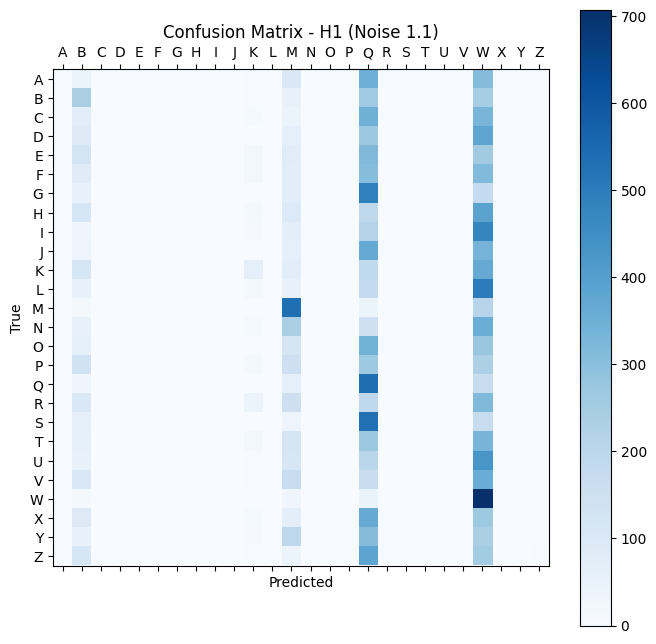

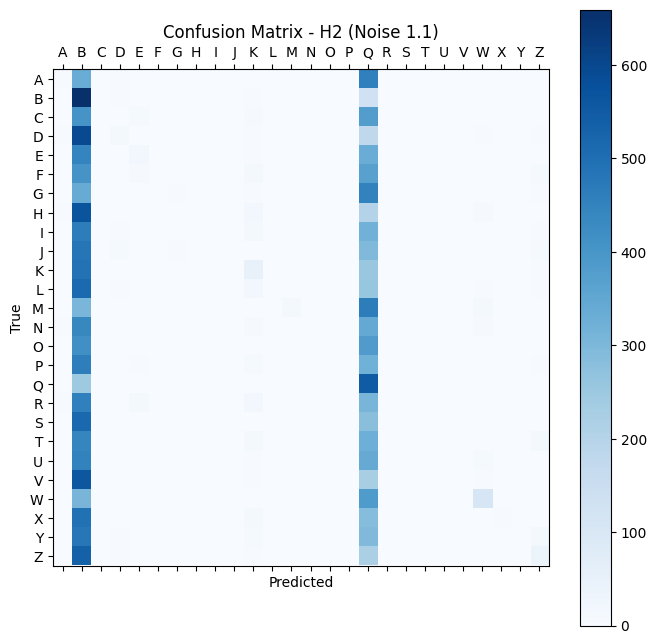

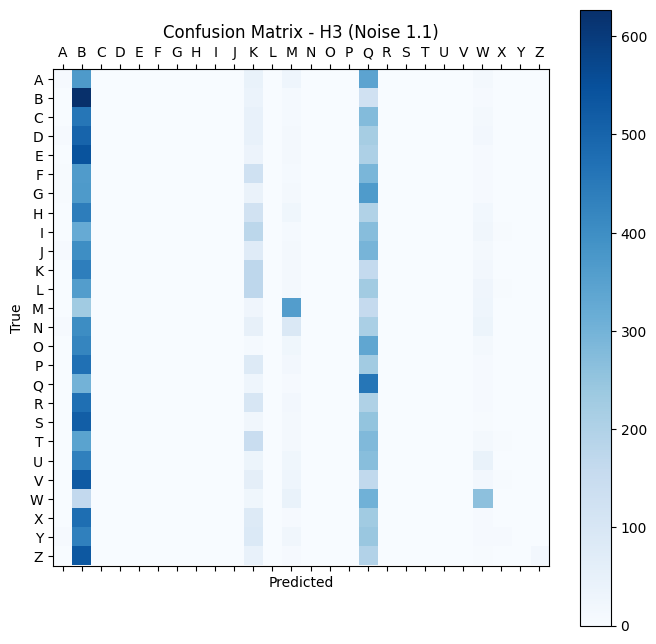

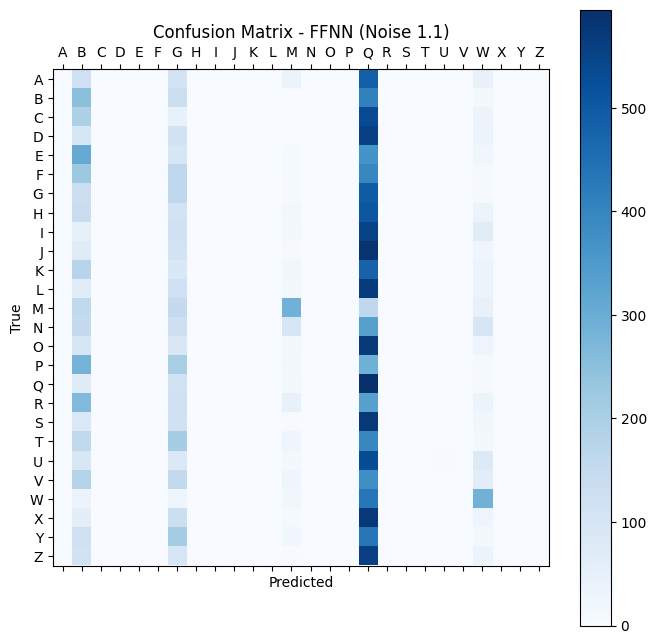

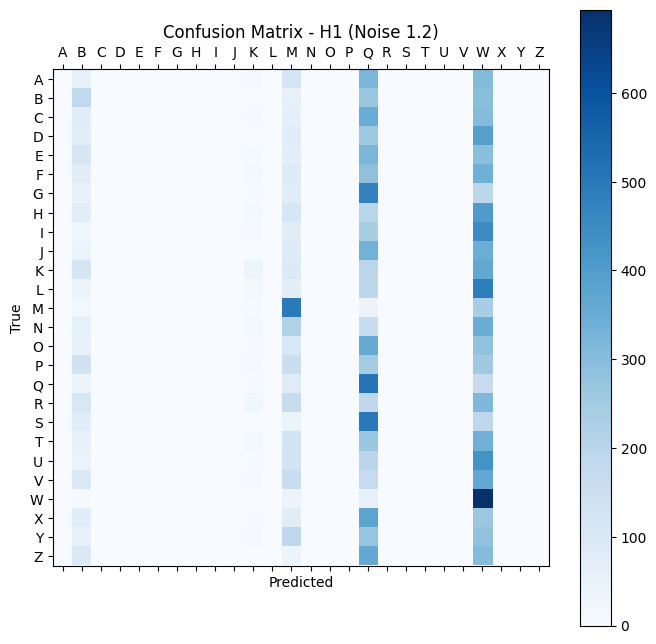

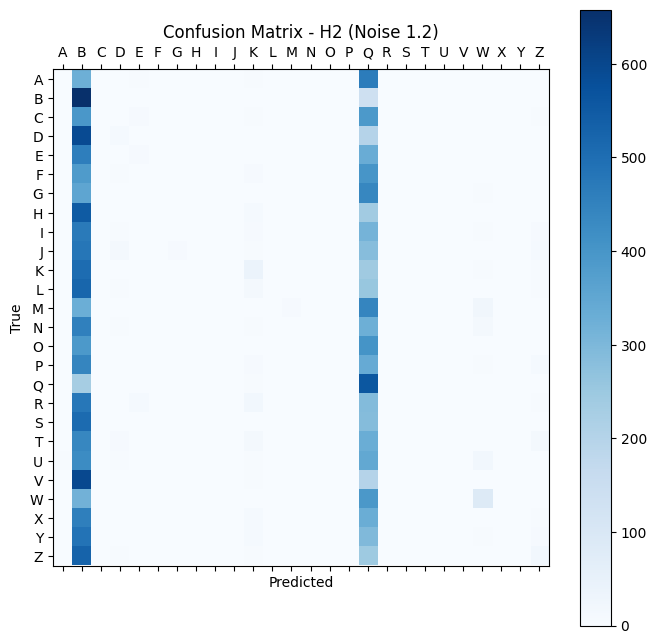

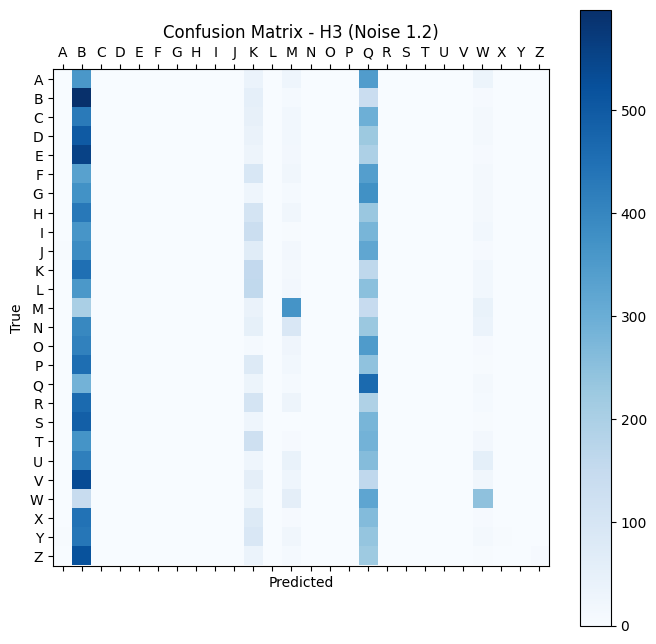

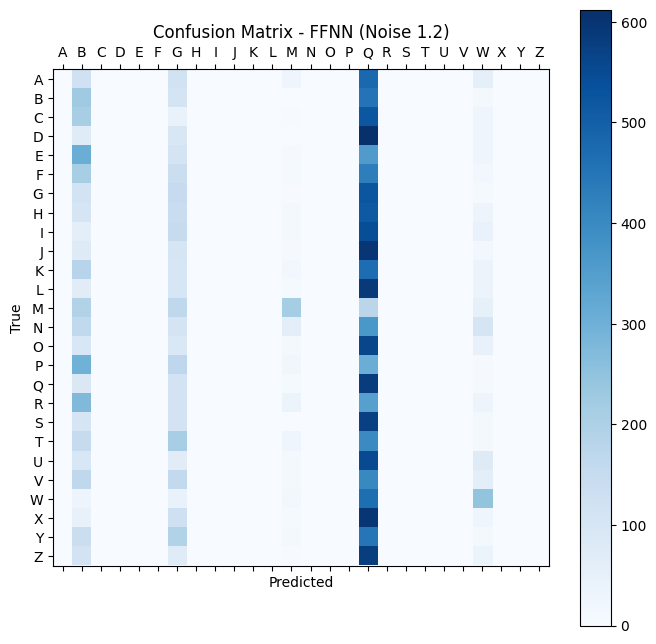

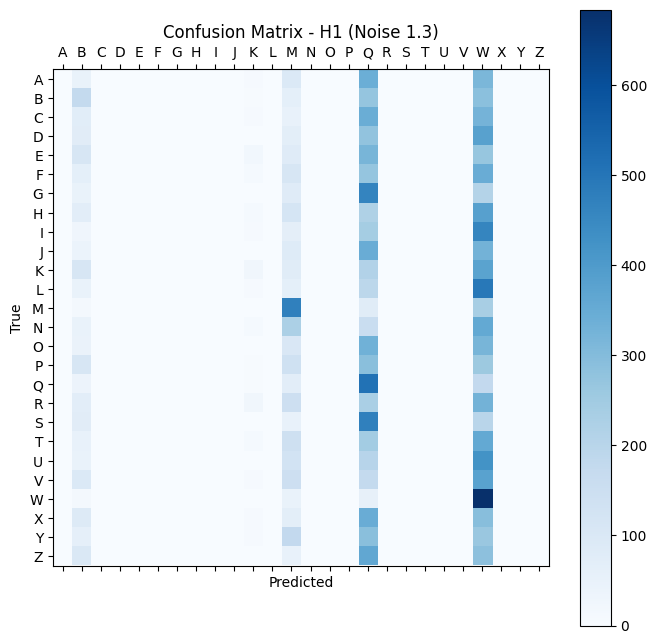

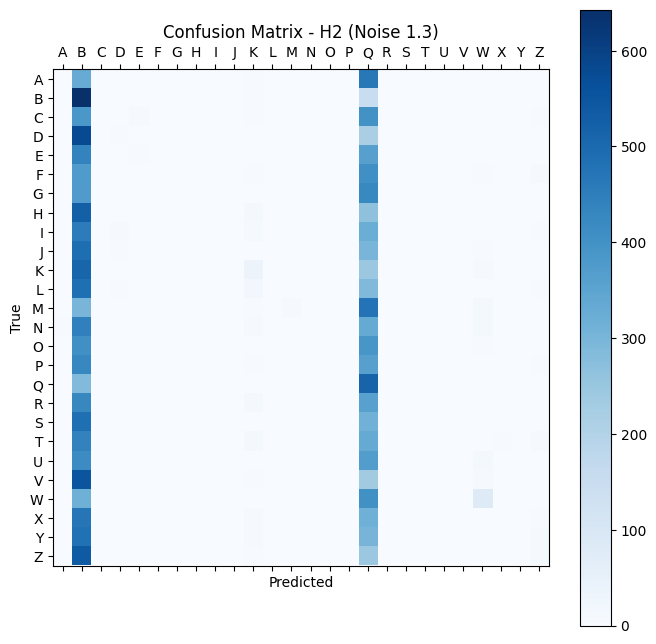

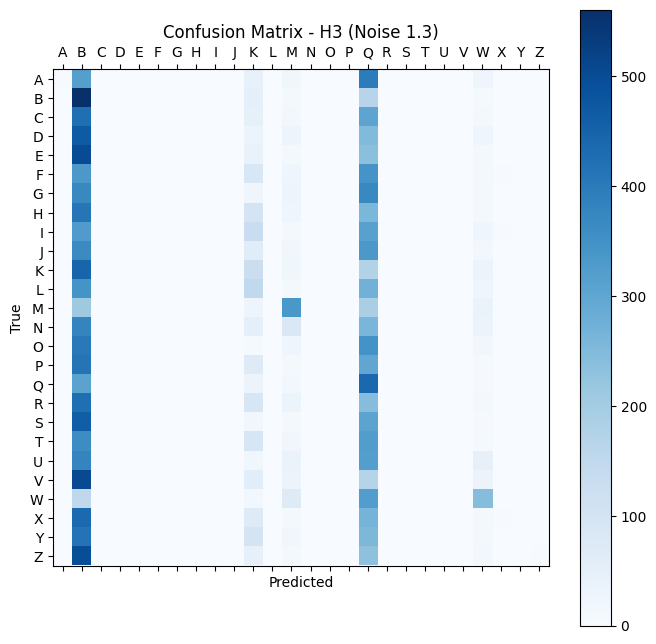

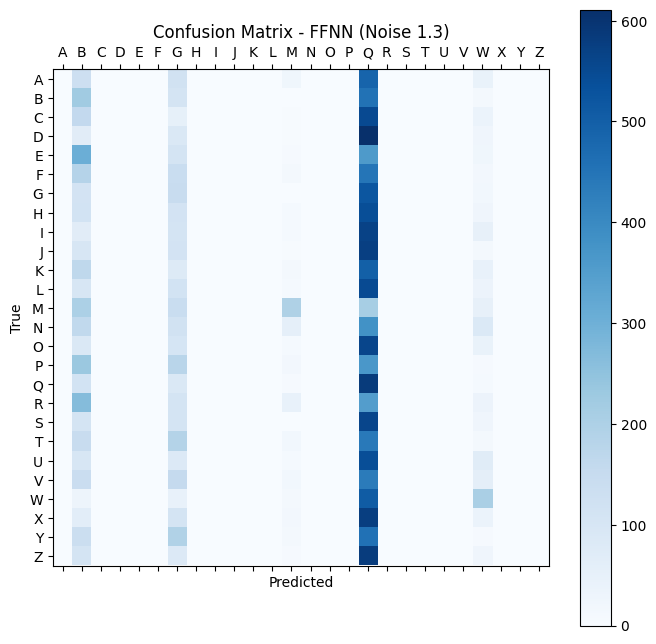

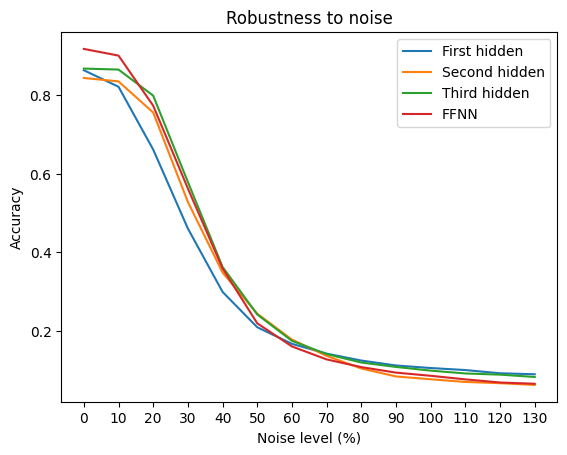

In [45]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_and_confusion_matrices(noise_levels)

From the confusion matrices we can observe how the models are classifying the examples as the noise increases, and we notice a that they particularly become biased towards letters B and Q.

As expected, we see that the performance of the FFNN remains on top of the others for low levels of noise, however, after a certain threshold its performance becomes much more comparable with the 3rd hidden layer of the DBN, and the latter surpasses the FFNN around the 20% noise mark.

The performance of the FFNN is still good for the reasons outlined in the previous section. In any case, we can now appreciate how the DBN is much more able to resist to noise perturbations than the simple supervised model.

##**Adversarial Attacks**

In [46]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [47]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [48]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

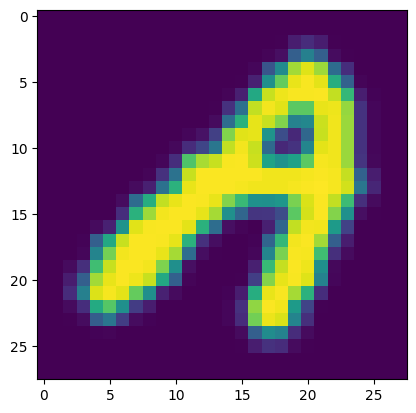

In [49]:
test_sample_idx = 100
test_image = emnist_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(correct_orientation(test_image.reshape(28,28).to('cpu')))

In [50]:
attacked_model = ffnn

In [51]:
attacked_model = dbn_with_readout

In [52]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
letter = target_to_letter(prediction)
print(f"The prediction of the model for this clean sample is {letter}.")

The prediction of the model for this clean sample is A.


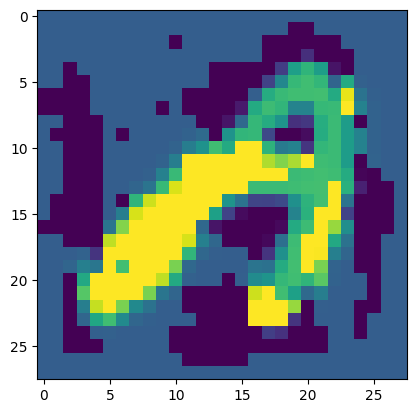

In [53]:
epsilon = 0.3  # strenght of the attack
test_image_label = emnist_te.targets[test_sample_idx].unsqueeze(0)
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data

perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
perturbed_image_np_rotated = np.rot90(perturbed_image_np.reshape(28, 28), k=3)
perturbed_image_np_flipped = np.fliplr(perturbed_image_np_rotated)
__ = plt.imshow(perturbed_image_np_flipped)

In [54]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
letter = target_to_letter(torch.argmax(model_outputs))
print(f"The prediction of the model for the perturbed sample is {letter}.")

The prediction of the model for the perturbed sample is B.


In the cells above, one can play with indexes and epsilon values to attack the two different models and visualize how they are affected.

In [55]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, print the result

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          image_np = data[0].detach().to('cpu').numpy()
          image_np_rotated = np.rot90(image_np.reshape(28, 28), k=3)
          image_np_flipped = np.fliplr(image_np_rotated)
          plt.imshow(image_np_flipped)
          plt.show()

        loss = functional.nll_loss(output, target - 1)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            pert_image_np = perturbed_data[0].detach().to('cpu').numpy()
            pert_image_np_rotated = np.rot90(pert_image_np.reshape(28, 28), k=3)
            pert_image_np_flipped = np.fliplr(pert_image_np_rotated)
            plt.imshow(pert_image_np_flipped)
            plt.show()

        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                rec_image_np = perturbed_data[0].detach().to('cpu').numpy()
                rec_image_np_rotated = np.rot90(rec_image_np.reshape(28, 28), k=3)
                rec_image_np_flipped = np.fliplr(rec_image_np_rotated)
                plt.imshow(rec_image_np_flipped)
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target - 1).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [56]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('../emnist', train=False, download=False, split = 'letters', transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [57]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 2.12%



In [58]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 13.54%



  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



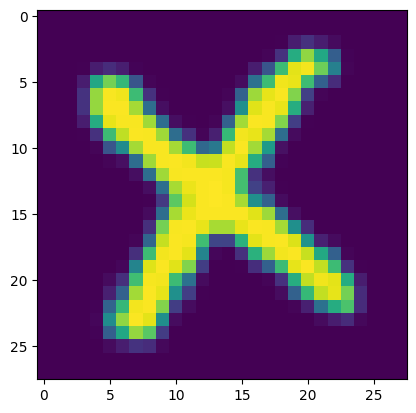


Here's a perturbed sample:



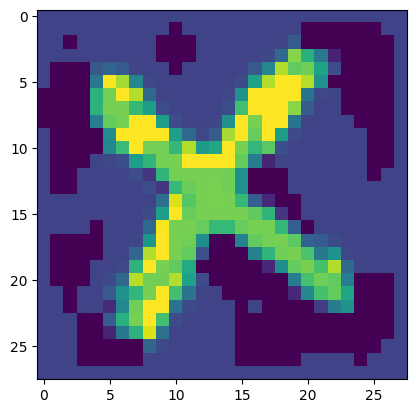


Here's what a 1-steps reconstructed sample looks like:



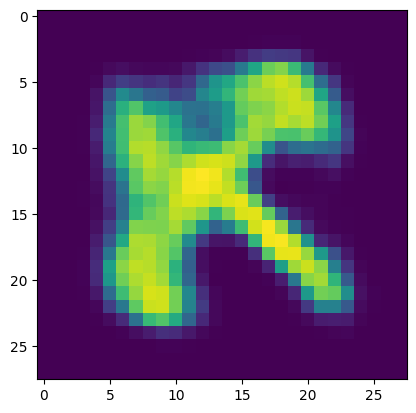


Epsilon: 0.2
Test Accuracy: 21.06%



In [59]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=1)

In [60]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [61]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

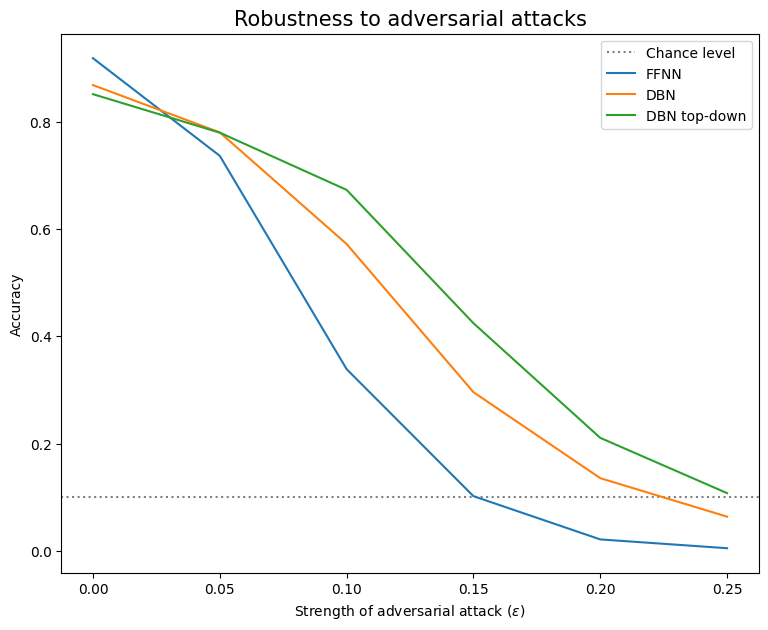

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The strength of DBNs can be clearly seen in this last plot.

In this adversarial attack we focused on the *fast gradient sign attack*, in which the attacker is basically introducing noise right at the input, not in the parameters, doing so by injecting noise which is concordant with the sign of the gradient calculated at a specific x, in order to increase the value of the loss function.

In DBNs a difense that can be applied is trying to reconstruct the perturbed input using top-down processing before classifying it, thus exploiting their generative power.

Given that the noise introduced this time is specifically tailored and not random as before, we see that perfomance degenerates even with relatively low values of epsilon. The most vulnerable to this kind of attack is the FFNN model, then we have the normal DBN, and even though this model is not using any defense strategy yet, it still outperforms the FFNN when attacked.

When the reconstruction step is applied to the DBN as a defense, this model significantly outperforms the other two alternatives and especially the FFNN. This DBN is much less affected by the attack. Of course, reconstruction might not be always correct when the attacks get stronger, it may lead to misclassification. However, this kind of attacks are mainly aimed at bringing unspottable modifications to the image in order to fool a human eye, so that no one would correct it. Hence, strong attacks can be effective but are also more noticeable.

This case particularly demonstrates why we consider DBNs a highly valuable model in the realm of concept learning.